In [1]:
from graph_tool.all import Graph, graph_draw
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import animation
from seaborn import heatmap, color_palette
from scipy import sparse

import nbimporter


# Utility Functions

In [2]:
def show_matrice(W):
    %matplotlib inline
    fig = plt.figure(figsize=(9,7))
    map = heatmap(W.todense(), cmap=color_palette("vlag", as_cmap=True))

In [20]:
def show_ei_matrix(Wee, Wei, Wie):
    plt.figure(figsize=(7,7))

    ax0 = plt.subplot2grid((n_e+n_i, n_e+n_i), (0, 0), colspan=n_i, rowspan=n_e)
    ax0.imshow(Wie.A, cmap=color_palette("vlag", as_cmap=True))
    ax0.axis('off')

    ax1 = plt.subplot2grid((n_e+n_i, n_e+n_i), (0, n_i), colspan=n_e, rowspan=n_e)
    ax1.imshow(Wee.A, cmap=color_palette("vlag", as_cmap=True))
    ax1.axis('off')

    ax2 = plt.subplot2grid((n_e+n_i, n_e+n_i), (n_e, 0), colspan=n_i, rowspan=n_i)
    ax2.imshow(np.zeros((n_i, n_i)), cmap=color_palette("vlag", as_cmap=True))
    ax2.axis('off')

    ax3 = plt.subplot2grid((n_e+n_i, n_e+n_i), (n_e, n_i), colspan=n_e, rowspan=n_i)
    ax3.imshow(Wei.toarray(), cmap=color_palette("vlag", as_cmap=True))
    ax3.axis('off')

    plt.show()


In [3]:
from graph_tool.all import arf_layout,  value_types, get_hierarchy_tree, radial_tree_layout, get_hierarchy_control_points, minimize_nested_blockmodel_dl
import matplotlib
from math import sqrt

def draw_network(W, Wout = None, Win = None):
    row, col= W.row, W.col
    W = W.toarray()/np.amax(W)
    n = len(W)
    
    # We add the edges
    edge_index = []
    pen_width = []
    for i in range(len(col)):
        edge_index.append((row[i], col[i]))
        pen_width.append(W[row[i]][col[i]])

    if Win is not None:
        for i in range(len(Win)):
            edge_index.append((n+1, i))
            pen_width.append(Win[i]/np.amax(Win))

    if Wout is not None:
        for i in range(len(Wout)):
            edge_index.append((i, n))
            pen_width.append(Wout[i]/np.amax(Wout))

    edge_index = np.array(edge_index)
    g = Graph(directed=True)
    g.add_edge_list(edge_index)
    
    edge_pen_width  =  g.new_edge_property("double")
    edge_pen_width.a = np.abs(pen_width)*4

    vertex_color = []
    vertex_text = []
#     color = g.new_vp("double")
    text = g.new_vp("double")
    for v in g.vertex_index:
#         vertex_color.append(Win[v])
        vertex_text.append(v)
#     color.a = vertex_color
    text.a = vertex_text
    pos = arf_layout(g)
    pos[n] = [7, 4]
    pos[n+1] = [1, 4]
 
    # The curvatures of the edges
    state = minimize_nested_blockmodel_dl(g)
    t = get_hierarchy_tree(state)[0]
    tpos = radial_tree_layout(t, t.vertex(t.num_vertices() - 1), weighted=True)
    cts = get_hierarchy_control_points(g, t, tpos)

        
    graph_draw(g, pos=pos, output_size=(1000, 1000), edge_control_points=cts, 
               edge_pen_width = edge_pen_width, vertex_size=10, vertex_text = text,
               vcmap=matplotlib.cm.inferno)


# Measurement

## Richness in reservoir
https://arxiv.org/pdf/1903.05174.pdf

In [4]:
def uncoupled_dynamics(W, Win, bias, state, U_test1, leaky_rate = 1, temp = 5000, A= 0.9):
    ST = []
    if state is None:
        state = np.random.uniform(-1, 1, n)
        
    for i in range(temp):
        ST.append(state)
        u = U_test1[i]
        state = update_reservoir(W, Win, u, state, leaky_rate, bias, activation_function)

    ST = np.array(ST)

    _, S, _ = np.linalg.svd(ST)
    R = []
    for s in S:
        R.append(s / np.sum(S))

    UD = 0
    frac = 0
    while frac < A:
        frac = frac + R[UD]
        UD+=1
    return UD, frac

# Reservoir functions

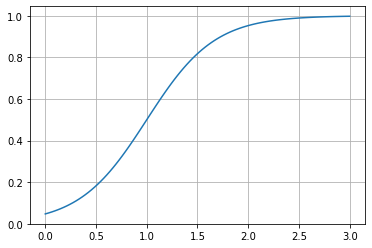

In [5]:
from importlib import reload
import reservoir.reservoir

from reservoir.reservoir import update_ei_reservoir, ridge_regression, train, run
from reservoir.reservoir import init_matrices
from reservoir.reservoir import synaptic_scaling, activation_target_definition, constant_synaptic_scaling
from reservoir.activation_functions import tanh, heaviside, sigmoid

reload(reservoir.reservoir)

# SEED
SEED = 3789

# the activation function choosen for the rest of the experiment

activation_function = lambda x : sigmoid(3*x-3)

plt.plot(np.linspace(0, 3, 100), activation_function(np.linspace(0, 3, 100)))
plt.grid()

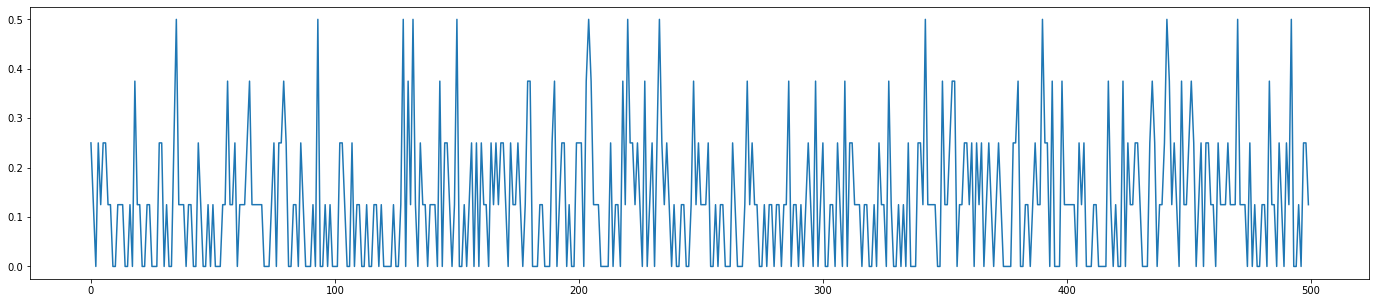

In [26]:
from scipy.stats import poisson

mu = 1
timesteps = 100000

U = poisson.rvs(mu, size=timesteps, random_state = SEED)[np.newaxis].T

# rescale between 0 and 1
U_train1 = (U - U.min()) / (U.max() - U.min())

plt.figure(figsize=(24,5))
plt.plot(range(500), U_train1[10000:10500])
plt.show()

# Simulation
https://www.nature.com/articles/s41598-018-22077-3#Fig1

In [7]:
from importlib import reload
import connexion_generation.activity_dependant_connexion
from connexion_generation.activity_dependant_connexion import compute_synaptic_change, add_activity_connexion
from connexion_generation.activity_dependant_connexion import select_pairs_connexion, select_pairs_pruning, change_connexion
reload(connexion_generation.activity_dependant_connexion)

<module 'connexion_generation.activity_dependant_connexion' from '/home/idlab278/Code/structural_plasticity/adsp/connexion_generation/activity_dependant_connexion.py'>

In [8]:
def count_incoming_connexions(W):
    incoming_connexion = W.nonzero()[0]
    incoming_connexion_count = np.zeros(W.shape[0])
    for i in incoming_connexion:
        incoming_connexion_count[i] +=1
    return incoming_connexion_count

In [9]:
# Parameters
n_e = 50 # number of neurons for excitatory pool
n_i = 20 # number of neurons for inhibitory pool
SEED = 3789
leaky_rate = 1
input_scaling = 1

spectral_radius = 1.45
input_connectivity =  0.745
connectivity = 0.075

# HPERPARAMETERS
INCREMENT = 20
VALUE = 0.1
bias_scaling = 1


# Initialisation EE
Win_ee, W_ee, bias_e =  init_matrices(n_e, input_connectivity, connectivity, spectral_radius, seed=SEED)
bias_e = bias_e*bias_scaling
Win_ee = Win_ee*input_scaling

# Initialisation EI
_, W_ei, _ =  init_matrices((n_i, n_e), 0, connectivity, spectral_radius, seed=SEED)

# Initialisation IE
_, W_ie, _ =  init_matrices((n_e, n_i), 0, connectivity, spectral_radius, seed=SEED)

# Initialisation II
_, _, bias_i =  init_matrices(n_i, 0, connectivity, spectral_radius, seed=SEED)
bias_i = bias_i*bias_scaling

# last_state
last_state_e = np.random.uniform(0, 1, n_e)
last_state_i = np.random.uniform(0, 1, n_i)

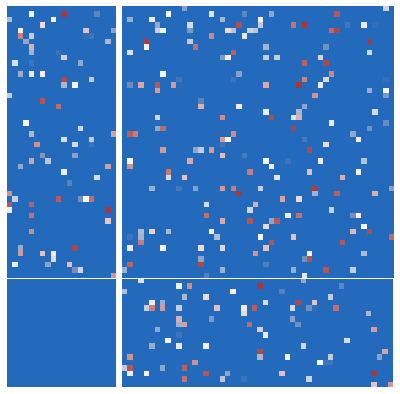

In [19]:
show_ei_matrix(W_ee, W_ei, W_ie)

## Evolution depending on target_rate and growth parameter

In [11]:
results = {"target_rate" : [] , "growth_parameter": [], "final_connectivity" : [], "convergence_step":[]}

for growth_parameter in np.logspace(-2, -0.1, 6):
    final_connectivity_by_level = []
    for target_rate in np.linspace(0.05, 0.95, 10):
        # Initialisation
        W_ee_adsp = W_ee.copy()
        W_ie_adsp = W_ie.copy()
        W_ei_adsp = W_ei.copy()
        U_train3 = U_train1.copy()
        state_e = last_state_e
        state_i = last_state_i
        
        train_length = len(U_train3)
        step=0
        total_add = 0
        total_prun = 0
        
        # Watched variables
        convergence_step = 0
        add = []
        prun = []
        incoming_connexion_count_history = []
        delta_z_history = []
        state_history =  []
        
        for i in range(INCREMENT):
            state_e, state_i = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_ee, U_train3[i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
            state_history.append(state_e)
        U_train3 = U_train3[INCREMENT:]
        train_length = len(U_train3)
        
        while total_add + total_prun< 3000 and train_length > 5000:

            incoming_connexion_count_history.append(count_incoming_connexions(W_ee_adsp))
            delta_z = compute_synaptic_change(state_history[-INCREMENT:], target_rate, growth_parameter, time_window = INCREMENT)
            
            W_ee_adsp, nb_new_add, nb_new_prun = add_activity_connexion(W_ee_adsp, state_e, delta_z, VALUE)

            for i in range(INCREMENT):
                state_e, state_i = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_ee, U_train3[i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
                state_history.append(state_e)
            U_train3 = U_train3[INCREMENT:]
            train_length = len(U_train3)
            
            total_add += nb_new_add
            total_prun += nb_new_prun
            add.append(total_add)
            prun.append(total_prun)
            if step > 5 and convergence_step == 0:
                mean_add = (add[-1]-add[-5])/2
                mean_prun = (prun[-1]-prun[-5])/2
                if prun[3] > add[3] and mean_add >= mean_prun: 
                    convergence_step = step
                if prun[3] < add[3] and mean_add <= mean_prun: 
                    convergence_step = step
            step +=1

        results["final_connectivity"].append(W_ee_adsp.count_nonzero()/n_e**2)
        results["convergence_step"].append(convergence_step)
        results["target_rate"].append(target_rate)
        results["growth_parameter"].append(growth_parameter)

In [12]:
df = pd.DataFrame.from_dict(results)

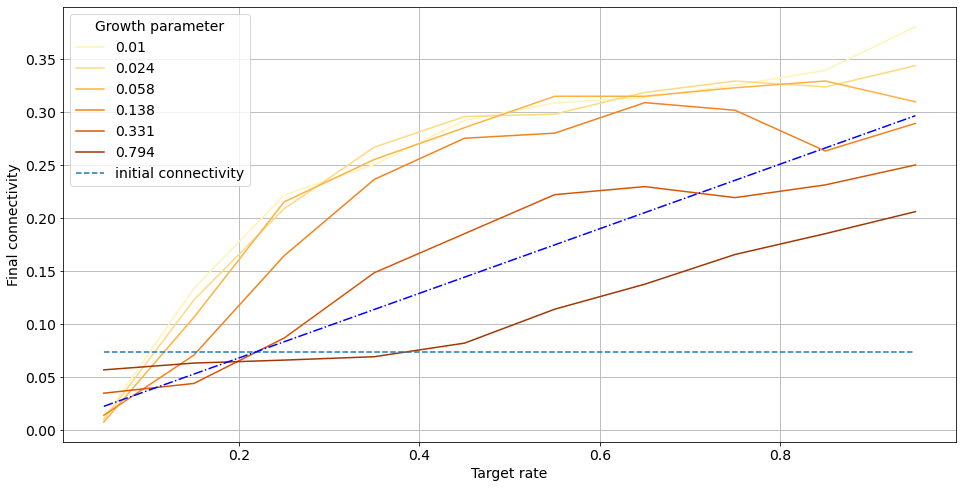

In [13]:
%matplotlib inline
MEDIUM_SIZE = 14
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes

fig, ax = plt.subplots(figsize=(16,8))
color_map = color_palette("YlOrBr", n_colors=6)

i = 0
for key, grp in df.groupby(['growth_parameter']):
    ax.plot(grp['target_rate'], grp['final_connectivity'], label=round(key*1000)/1000, c = color_map[i])
    i += 1
ax.plot(np.linspace(0.05, 0.95, 10), [W_ee.count_nonzero()/n_e**2]*10, linestyle = "--", label="initial connectivity")

mean_low = df.loc[df["target_rate"]  == 0.05]["final_connectivity"].mean()
mean_high = df.loc[df["target_rate"]  == 0.95]["final_connectivity"].mean()
ax.plot([0.05, 0.95], [mean_low, mean_high],linestyle = "-.", c = "b")

ax.legend( title="Growth parameter")
ax.set_xlabel('Target rate')
ax.set_ylabel('Final connectivity')
ax.grid(True)

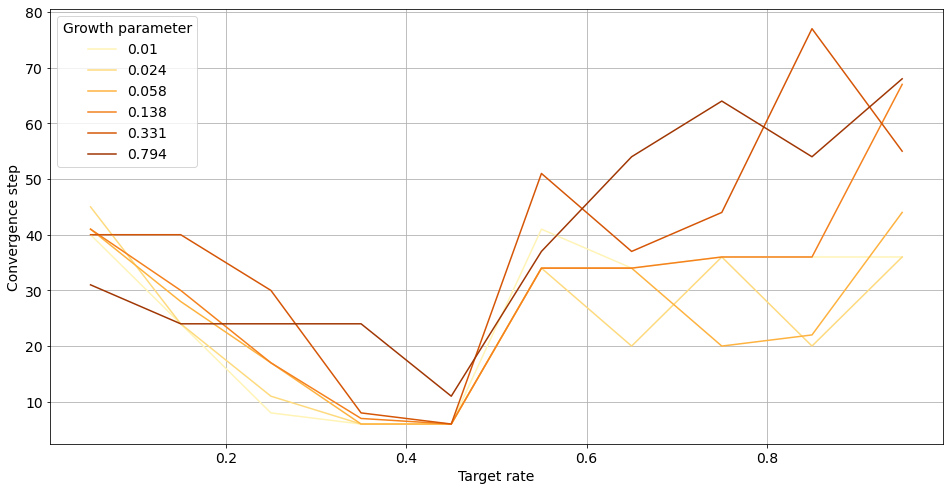

In [14]:
%matplotlib inline
MEDIUM_SIZE = 14
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes

color_map = color_palette("YlOrBr", n_colors=6)

i = 0
fig, ax = plt.subplots(figsize=(16,8))
for key, grp in df.groupby(['growth_parameter']):
    ax.plot(grp['target_rate'], grp['convergence_step'], label=round(key*1000)/1000, c = color_map[i])
    i += 1
    
ax.legend( title="Growth parameter")
ax.set_xlabel('Target rate')
ax.set_ylabel('Convergence step')
ax.grid(True)

## Grid of 

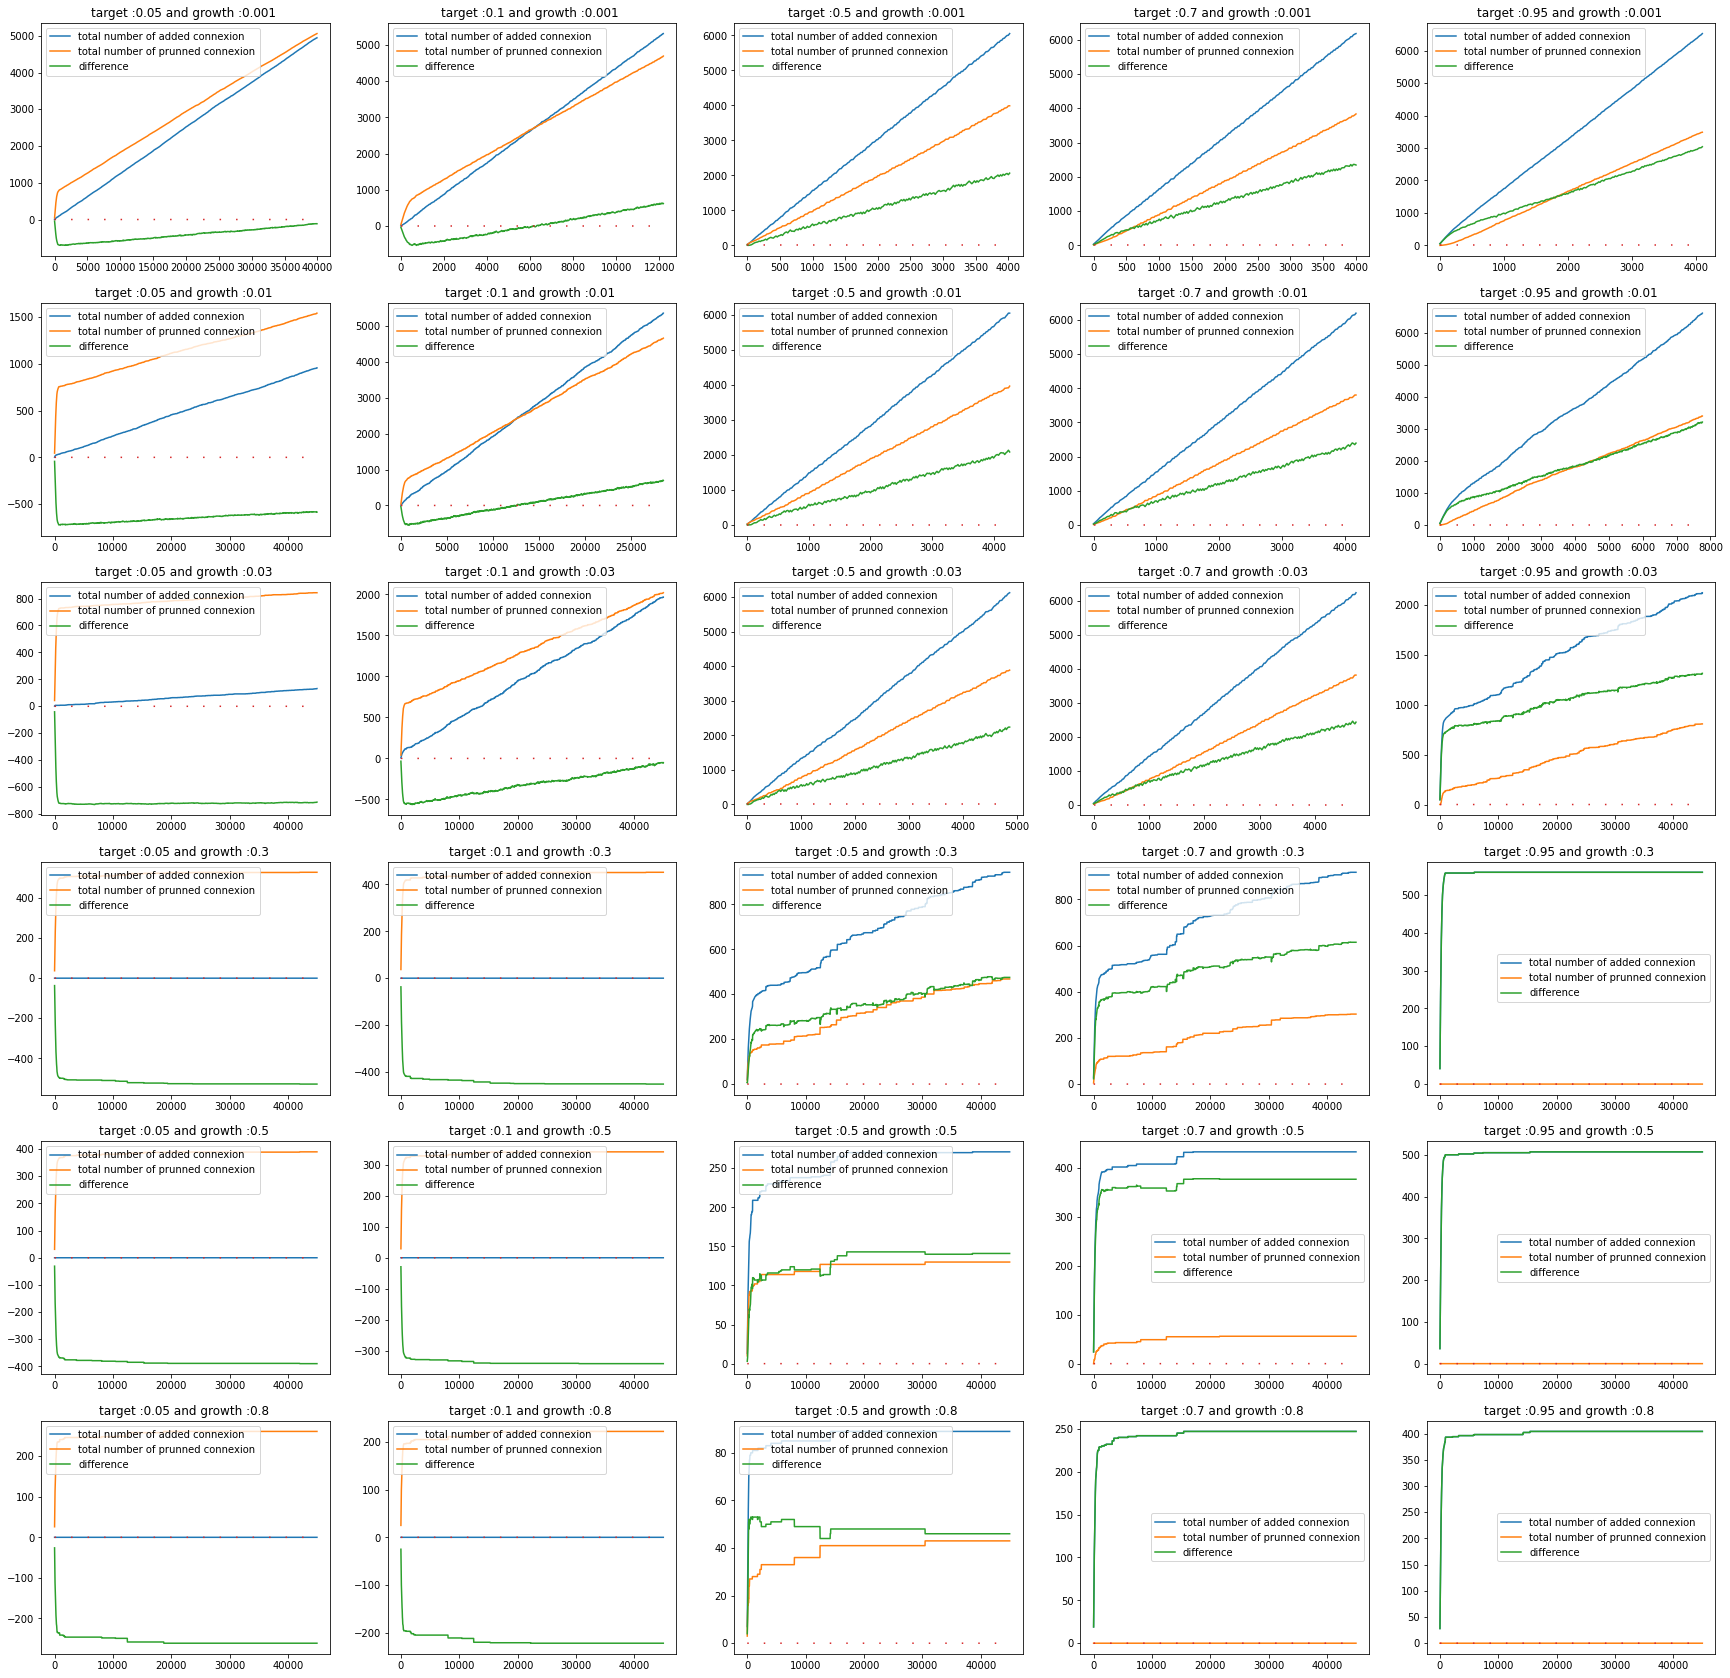

In [15]:
%matplotlib inline

# The parameters you want to see the influence
fig, ax = plt.subplots(6, 5, figsize=(30,30))
k = 0
for growth_parameter in [0.001, 0.01, 0.03, 0.3, 0.5, 0.8]:
    j = 0
    for target_rate in [0.05, 0.1, 0.5, 0.7, 0.95]:

        # Initialisation
        W_ee_adsp = W_ee.copy()
        W_ie_adsp = W_ie.copy()
        W_ei_adsp = W_ei.copy()
        U_train3 = U_train1.copy()
        state_e = last_state_e
        state_i = last_state_i
        
        step=0
        convergence_step = 0

        total_add = 0
        total_prun = 0
        add = []
        prun = []
        mean_prun = []

        incoming_connexion_count_history = []
        state_history = []
        delta_z_history = []

        for i in range(INCREMENT):
            state_e, state_i = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_ee, U_train3[i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
            state_history.append(state_e)
        U_train3 = U_train3[INCREMENT:]
        train_length = len(U_train3)
        
        while total_add + total_prun < 10000 and train_length > 5000:

            incoming_connexion_count_history.append(count_incoming_connexions(W_ee_adsp))
            delta_z = compute_synaptic_change(state_history[-INCREMENT:], target_rate, growth_parameter, time_window = INCREMENT)
            delta_z_history.append(delta_z)
            W_ee_adsp, nb_new_add, nb_new_prun = add_activity_connexion(W_ee_adsp, state_e, delta_z, VALUE)

            for i in range(INCREMENT):
                state_e, state_i = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_ee, U_train3[i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
                state_history.append(state_e)
            U_train3 = U_train3[INCREMENT:]
            train_length = len(U_train3)
        
            
            total_add += nb_new_add
            total_prun += nb_new_prun
            add.append(total_add)
            prun.append(total_prun)
            if step > 5 and convergence_step == 0:
                mean_add = (add[-1]-add[-5])/2
                mean_prun = (prun[-1]-prun[-5])/2
                if prun[3] > add[3] and mean_add >= mean_prun: 
                    convergence_step = step
                if prun[3] < add[3] and mean_add <= mean_prun: 
                    convergence_step = step
            step +=1
        add = np.array(add)
        prun = np.array(prun)
        ax[k][j].plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
        ax[k][j].plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
        ax[k][j].plot(np.arange(step)*INCREMENT, add-prun, label="difference")
        ax[k][j].plot(np.arange(step)*INCREMENT, [0]*step, linestyle=(0, (1, 10)))
        ax[k][j].title.set_text(f'target :{target_rate} and growth :{growth_parameter} ')
        ax[k][j].legend()
        j+=1    
    k+= 1


## Visualisation of one evolution 

### first set of parameters

In [16]:
# Parameters
# The parameters you want to see the influence

growth_parameter = 0.3
target_rate=0.5

# Initialisation
W_ee_adsp = W_ee.copy()
W_ie_adsp = W_ie.copy()
W_ei_adsp = W_ei.copy()
U_train3 = U_train1.copy()
state_e = last_state_e
state_i = last_state_i

train_length = len(U_train3)
step=0
convergence_step = 0

total_add = 0
total_prun = 0
add = []
prun = []
mean_prun = []

incoming_connexion_count_history = []
state_history = []
delta_z_history = []

for i in range(INCREMENT*5):
    state_e, state_i = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_ee, U_train3[i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
    state_history.append(state_e)
U_train3 = U_train3[INCREMENT*5:]
train_length = len(U_train3)

while total_add + total_prun < 5000 and train_length > 5000:

    incoming_connexion_count_history.append(count_incoming_connexions(W_ee_adsp))
    delta_z = compute_synaptic_change(state_history[-INCREMENT:], target_rate, growth_parameter, time_window = INCREMENT)
    delta_z_history.append(delta_z)
    W_ee_adsp, nb_new_add, nb_new_prun = add_activity_connexion(W_ee_adsp, state_e, delta_z, VALUE)

    for i in range(INCREMENT):
        state_e, state_i = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_ee, U_train3[i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
        state_history.append(state_e)
    U_train3 = U_train3[INCREMENT:]
    train_length = len(U_train3)

    length = len(U_train3)
    total_add += nb_new_add
    total_prun += nb_new_prun
    add.append(total_add)
    prun.append(total_prun)
    if step > 5 and convergence_step == 0:
        mean_add = (add[-1]-add[-5])/2
        mean_prun = (prun[-1]-prun[-5])/2
        if prun[3] > add[3] and mean_add >= mean_prun: 
            convergence_step = step
        if prun[3] < add[3] and mean_add <= mean_prun: 
            convergence_step = step
    step +=1
add = np.array(add)
prun = np.array(prun)

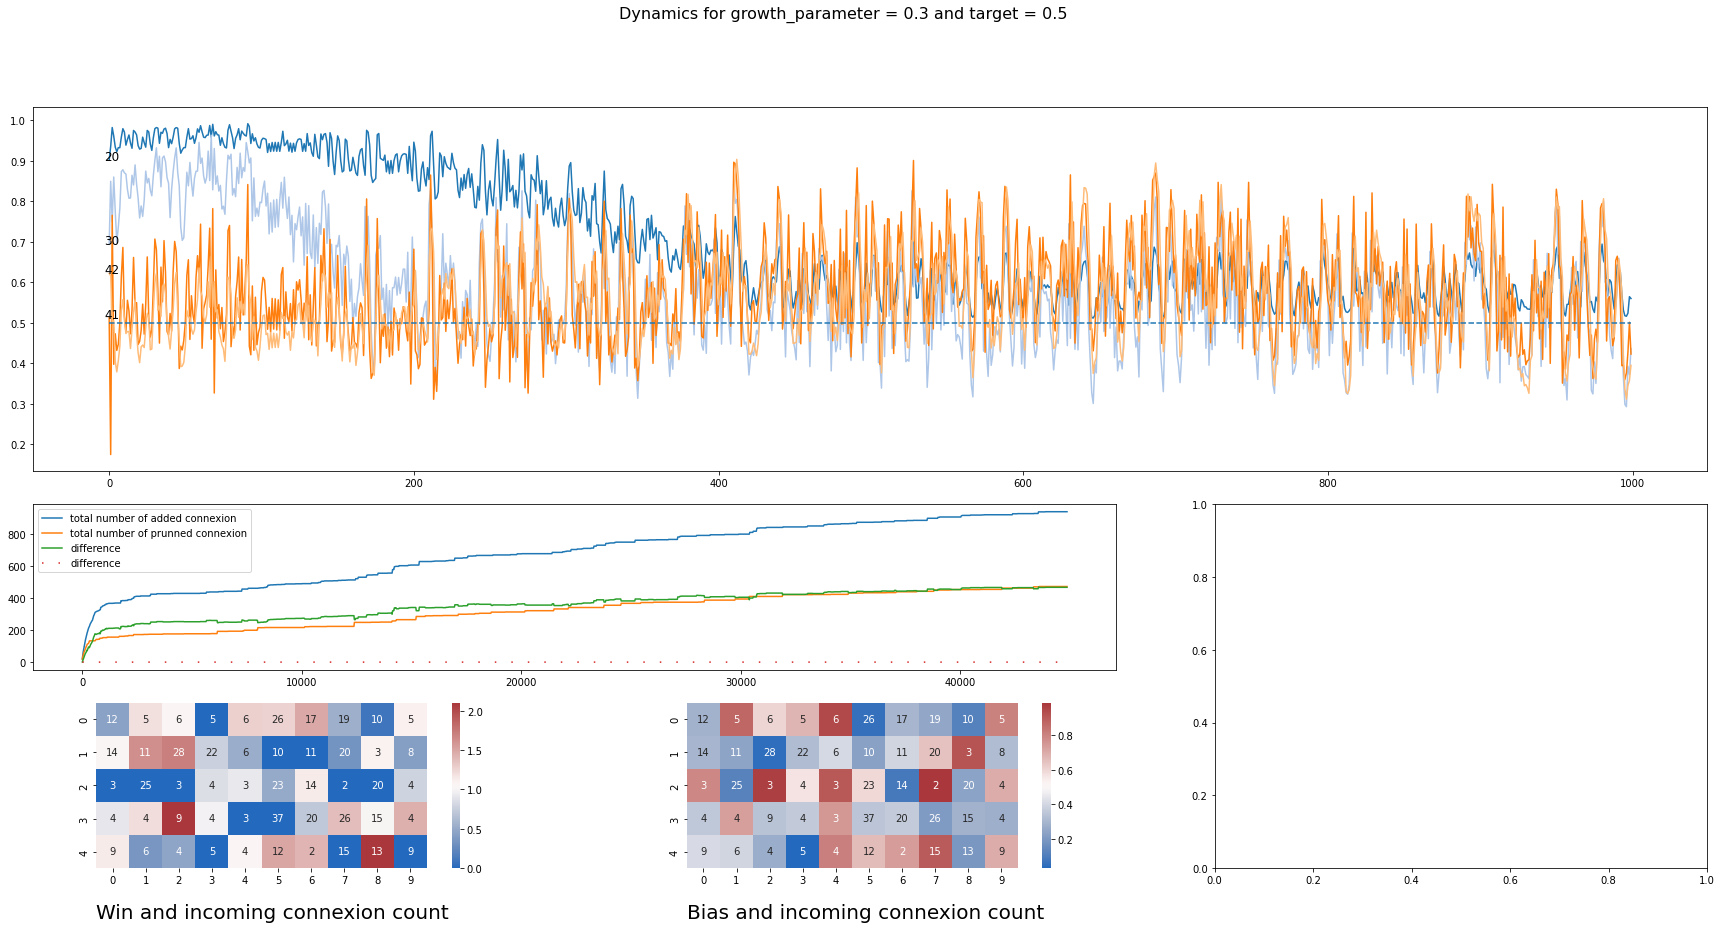

In [17]:
from math import copysign

plt.figure(figsize=(30,14))
plt.suptitle(f'Dynamics for growth_parameter = {growth_parameter} and target = {target_rate}', fontsize=16)

# NEURON ACTIVITY PLOT 
ax0 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=2)
random_neurons_indices =  np.sort(np.random.randint(n_e, size=4)) #Size max is 19 because there is not enough colors
colors = color_palette("tab20")
    # NUMBER_OF_STEP_TO_WATCH 
WATCH_FROM = 0
WATCH_TO = 1000
neurons_evolution = np.array(state_history)[WATCH_FROM:WATCH_TO]
x =range(step*INCREMENT)[WATCH_FROM:WATCH_TO]
j = 0
for i in random_neurons_indices:
    ax0.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    ax0.text(-3+WATCH_FROM, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1
ax0.plot(x, [target_rate]*(WATCH_TO-WATCH_FROM), linestyle = "--", label="initial connectivity")
# plt.legend(fontsize=16, loc="right")


# TOTAL ADDITION AND PRUNING OF CONNEXIONS 
ax1 = plt.subplot2grid((4, 3), (2, 0), colspan=2)
ax1.plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
ax1.plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
ax1.plot(np.arange(step)*INCREMENT, add-prun, label="difference")
ax1.plot(np.arange(step)*INCREMENT, [0]*step, linestyle=(0, (1, 10)), label="difference")

ax1.legend()

ax3 = plt.subplot2grid((4, 3), (2, 2), rowspan=2)

ax4 = plt.subplot2grid((4, 3), (3, 0))
heatmap(Win_ee.A.reshape(5,10), square=True, cmap=color_palette("vlag", as_cmap=True)
            , annot = incoming_connexion_count_history[-1].reshape(5,10), ax = ax4)
ax4.text(0, 6.5, 'Win and incoming connexion count',fontsize=20)

ax5 = plt.subplot2grid((4, 3), (3, 1))
heatmap(bias_e.reshape(5,10), square=True, cmap=color_palette("vlag", as_cmap=True)
            , annot = incoming_connexion_count_history[-1].reshape(5,10), ax = ax5)
ax5.text(0, 6.5, 'Bias and incoming connexion count',fontsize=20)

plt.show()